# Libraries and modules

In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import seaborn

# Functions

In [49]:
def fiji_init(ram = 30, fiji_path = '/home/jacquouaisse/Documents/fiji-linux64/Fiji.app'):
    scyjava.config.add_option(f'-Xmx{ram}g') # this is to assign RAM to the java session
    ij = imagej.init(fiji_path, mode='interactive')
    ij.ui().showUI()
    ij.getVersion()
    rm = ij.RoiManager.getRoiManager()
    return rm, ij

def define_directory_path():
    root = tk.Tk()
    root.withdraw()
    directory_path = filedialog.askdirectory()
    return directory_path
    
def get_z_projection_nuclei(directory_path, method='max', wanted_channel=0, nuclei_channel_name= "nuclei", sigma=1.5):
    # Get a list of all the folders in the directory
    folder_list = os.listdir(directory_path)    
    # Iterate over the folders and process each folder
    for folder in folder_list:
        # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
        # Find all the czi files in the folder
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        # Iterate through the files and apply the image analysis workflow to each image
        for file_path in file_list:
            result_path = os.path.splitext(file_path)[0] + f"_{nuclei_channel_name}.tif"
            if os.path.exists(result_path):
                os.remove(result_path)
            image = ij.io().open(file_path) # opening the image
            blue_channel = image[:, :, wanted_channel,:]
            # Cellpose segmentation for nuclei worked better with a smoothed nuclear signal, specially with low signal. Smoothing workflow :
            smoothed_image = ij.op().run("smooth", blue_channel, sigma)
            imp = ij.py.to_imageplus(smoothed_image) # convert the image into the imageplus type object needed for z-projection
            # Z-projection
            z_projector_result = ZProjector.run(imp, method)
            z_collapsed_image = ij.py.from_java(z_projector_result)
            z_collapsed_dataset = ij.py.to_dataset(z_collapsed_image)
            # Save as a TIFF imagerm.open(f"{input_roi}")
            ij.io().save(z_collapsed_dataset, result_path)
            print(f"Saving image {result_path}.")
    return nuclei_channel_name

def get_z_projection_bact(directory_path, method='sum', wanted_channel=1):
    channel = wanted_channel    
    # Get a list of all the folders in the directory
    folder_list = os.listdir(directory_path)
    # Iterate over the folders and process each folder
    for folder in folder_list:
        folder_path = os.path.join(directory_path, folder)
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
    
        for file_path in file_list:
            image = ij.io().open(file_path)
            blue_channel = image[:, :, channel,:]
            imp = ij.py.to_imageplus(blue_channel)
            z_projector_result = ZProjector.run(imp, method)
            z_collapsed_image = ij.py.from_java(z_projector_result)
            z_collapsed_dataset = ij.py.to_dataset(z_collapsed_image)  
        # Save the results, add a suffix "bact" for bacterial channel
            result_path = os.path.splitext(file_path)[0] + "_bactSUM.tif"
            if os.path.exists(result_path):
                os.remove(result_path)
        # Save as a TIFF image
            ij.io().save(z_collapsed_dataset, result_path)
            print(f"Saving image {result_path}.")

def single_slice_channel(directory_path, wanted_channel=1, wanted_z = 2, channel_name = "tpmt"):
    # Get a list of all the folders in the directory
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
        # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
        # Find all the ".czi" files in the folder
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        for file_path in file_list:
            image = ij.io().open(file_path)
            wanted_channel = 1
            wanted_z = 2
            wanted_image = image[:, :, wanted_channel, wanted_z]
            result_path = os.path.splitext(file_path)[0] + f"_{channel_name}.tif"
            cellpose_image = ij.py.to_dataset(wanted_image)
            ij.io().save(cellpose_image, result_path)
            print(f"Saving image {result_path}.")

def roi_export(folder_path, file_path, nuclei_channel_name):
    f_name = os.path.basename(file_path)
    f_name = os.path.splitext(f_name)[0]
    imp = ij.IJ.openImage(file_path)
    input_txt = Path(f"{folder_path}/{f_name}_cp_outlines.txt")
    txt_fh = open(input_txt, 'r')
    for line in txt_fh:
        xy = line.rstrip().split(",")
        xy_coords = [int(element) for element in xy if element not in '']
        x_coords = [int(element) for element in xy[::2] if element not in '']
        y_coords = [int(element) for element in xy[1::2] if element not in '']
        xcoords_jint = JArray(JInt)(x_coords)
        ycoords_jint = JArray(JInt)(y_coords)
        polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
        roi_instance = scyjava.jimport('ij.gui.Roi')
        imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
        imp.setRoi(imported_polygon)
        rm.addRoi(imported_polygon)
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Save", f"{folder_path}/{f_name}.zip")
    rm.runCommand("Reset")

def cellpose_segmentation(directory_path, nuclei_channel_name, model_name = 'raw'):
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
        folder_path = os.path.join(directory_path, folder)
        file_pattern = os.path.join(folder_path, f"*{nuclei_channel_name}.tif")
        file_list = glob.glob(file_pattern)
        model = models.CellposeModel(gpu=True, model_type=model_name)
        for file_path in file_list:
            imgs = io.imread(file_path)
            channels = [[0,0]]
            masks, flows, styles = model.eval(imgs, diameter=None, channels=channels)
            io.save_masks(imgs, masks, flows, file_path, save_txt=True)
            roi_export(folder_path, file_path, nuclei_channel_name)

def voronoi_segmentation(directory_path, nuclei_channel_name):
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
        # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
        file_list = os.listdir(folder_path)
        for file_path in file_list:
            if file_path.endswith(".czi"):
                basename = os.path.basename(file_path)
                corename = os.path.splitext(basename)[0]                
                image_path = f"{folder_path}/{corename}_{nuclei_channel_name}.tif"
                imp = ij.IJ.openImage(image_path)
                set_string = f'Set Measurements...'
                measure_string = f'centroid redirect=None decimal=1'
                ij.IJ.run(set_string, measure_string)
                imp.show()
                roi_path = f"{folder_path}/{corename}_{nuclei_channel_name}.zip"
                rm.open(f"{roi_path}")
                Macro_voronoi = """
        nbArea=roiManager("count")
    for (i=0; i<nbArea; i++) {
    		roiManager("Select", i);
    		run("Enlarge...", "enlarge=-1 pixel");
    		roiManager("update");	
    	}
    
    array1 = newArray("0");;
    for (i=1;i<roiManager("count");i++){
            array1 = Array.concat(array1,i);
    }
    	roiManager("select", array1);
    	roiManager("XOR");
    	roiManager("Fill");
    	roiManager("select", array1);
    	roiManager("XOR");
    	run("Clear Outside");
    	roiManager("Delete")
    setThreshold(255, 255);
    run("Convert to Mask", "method=Default background=Dark black");
    
    //Voronoi ROI generations
    
    run("Set Measurements...", "center redirect=None decimal=1");
    	run("Analyze Particles...","size=3-Infinity display clear");
    	//Resolution de l'image pwidth et pheight
    	getPixelSize(unit, pw, ph, pd);
    	//Voronio
    	run("Voronoi");
    	setThreshold(0, 0,"black & white");
    	
    	//Wand to ROI Manager
    	x=newArray(nResults);
    	y=newArray(nResults);
    	nbPoints=nResults;
    	
    	for (i=0; i<nbPoints; i++) {
    		x[i]=getResult("XM",i)/pw;
    		y[i]=getResult("YM",i)/ph;
    	}
    	for (i=0; i<nbPoints; i++) {
    		doWand(x[i], y[i], 156.0, "Legacy");
    		roiManager("Add");
    	}
    
    	//Center of mass
    	/*
    	x=newArray(nResults);
    	y=newArray(nResults);
    	for (i=0; i<nResults; i++) {
    		x[i]=getResult("XM",i)/pw;
    		y[i]=getResult("YM",i)/ph;
    	}
    	*/
    	makeSelection("point", x, y);
        selectWindow("Results");
        run("Close");
        close("*");
        """
                ij.py.run_macro(Macro_voronoi)   
                rm.runCommand("Select All")
                rm.runCommand("Save", f"{folder_path}/{corename}_voronoi.zip") # this saves the ROIs as a zip file
                rm.runCommand("Delete")

def get_bacteria_channel(directory_path, wanted_channel = 1):
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
        folder_path = os.path.join(directory_path, folder)
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        for file_path in file_list:
            image = ij.io().open(file_path)
            wanted_image = image[:, :, wanted_channel, :]
            ij.ui().show(wanted_image)
            # The following macro is showing how to use the smooth function in Fiji can be used.
            # Any image opened and displayed will be formatted as a virtual stack. The duplication allows to remove this formatting.
            duplicated = ij.IJ.run("Duplicate...", "duplicate")
            smoothed1 = ij.IJ.run("Smooth", "stack")
            smoothed2 = ij.IJ.run("Smooth", "stack")
            result_path = os.path.splitext(file_path)[0] + "_bact.tif"
            set_string = f'saveAs("Tiff", "{result_path}")'
            ij.py.run_macro(set_string)
            ij.py.run_macro("close();")
            ij.py.run_macro("close();")

def get_area_values(directory_path, threshold_low = 15, threshold_high = 255, distance=1024, known=202.83, unit="µm"):
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
    # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        for file_path in file_list:
            basename = os.path.basename(file_path)
            corename = os.path.splitext(basename)[0]
            image_path = f"{folder_path}/{corename}_bact.tif"
            basename2 = os.path.basename(image_path)
            imp = ij.IJ.openImage(image_path)
            imp.show()
            input_ROI = Path(f"{folder_path}/{corename}_voronoi.zip")
            rm.open(f"{input_ROI}")
            ij.IJ.run("Set Measurements...", f'area limit redirect=None decimal=2')
            ij.IJ.setAutoThreshold(imp, "Default dark")
            ij.IJ.setRawThreshold(imp, threshold_low, threshold_high)
            ij.IJ.run(imp, "Convert to Mask", "background=Dark black")
            ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known} unit={unit}");')    
            roi_count = rm.getCount()
            for i in range(0, roi_count):
                rm.select(i)
                ij.IJ.run(imp, "Analyze Particles...", f"summarize stack")
            window_name = f"Summary of {basename2}"
            ij.IJ.selectWindow(window_name)
            ij.IJ.renameResults(f"{window_name}", "Results")
            output_path = Path(f"{folder_path}/{corename}_area.csv").as_posix()
            ij.IJ.saveAs("Results", output_path)
            ij.IJ.run("Clear Results")
            w.getWindow("Results").close()
            rm.runCommand("Reset")
            ij.py.run_macro('close("*");')
                         

def calculate_total_volume_per_cell(df, slice_number, slice_distance):
    """Calculates the sum of the "Total Area" for each pattern of the "Slice" column.

    Args:
        df: A pandas DataFrame containing the data.

    Returns:
        A pandas DataFrame containing the sum of the "Total Area" for each pattern of the "Slice" column.
    """

    # Create a list to store the DataFrames with results.
    results = []

    # Loop through the DataFrame.
    for i in range(len(df)):
        # If the current cell value in the "Slice" column is 1,
        if df['Slice'][i] == 1:
            # Sum the "Total Area" column for the next 10 rows.
            #slice_number = 10  # You need to define slice_number and slice_distance
            #slice_distance = 1  # You need to define slice_number and slice_distance
            bacterial_area = df['Total Area'][i:i + slice_number].sum()
            bacterial_volume = bacterial_area * slice_distance
            results.append(bacterial_volume)

    # Return the final results DataFrame.
    return results

def volume_measurement(slices = 11, distance = 1):
    slice_number = slices
    slice_distance = distance
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
        # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
    
        # Find all the z-projected nuclear files in the folder
        file_pattern = os.path.join(folder_path, "*_area.csv")
        file_list = glob.glob(file_pattern)
        final_results = []
        for file_path in file_list:
            # Read the DataFrame.
            df = pandas.read_csv(file_path)
    
            # Calculate the sum of the "Total Area" for each pattern of the "Slice" column.
            results = calculate_total_volume_per_cell(df, slice_number, slice_distance)
            final_results.extend(results)
    
        df_results = pandas.DataFrame({'bacterial_volume' : final_results})
        f_name = os.path.basename(folder_path)
        #f_name = os.path.splitext(f_name)[0]
        output_path = Path(f"{folder_path}/{f_name}.csv")
        df_results.to_csv(output_path)

def get_total_fluorescence(directory_path, threshold_low = 55.2):
    folder_list = os.listdir(directory_path)    
    for folder in folder_list:
        # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        for file_path in file_list:
            basename = os.path.basename(file_path)
            corename = os.path.splitext(basename)[0]
            image_path = f"{folder_path}/{corename}_bactSUM.tif"
            basename2 = os.path.basename(image_path)
            corename2 = os.path.splitext(basename2)[0]
            
            image = ij.io().open(image_path)
            ij.ui().show(image)
            imp = ij.py.to_imageplus(image)
            input_ROI = Path(f"{folder_path}/{corename}_voronoi.zip")
            duplicated = ij.IJ.run("Duplicate...", "duplicate")
            image_name = f"{corename2}-1.tif"
            imp1 = w.getImage(str(image_name))

            ij.IJ.setAutoThreshold(imp1, "Default dark")
            ij.IJ.setRawThreshold(imp1, threshold_low, 1000000000000000000000000000000.0000)
            ij.IJ.run(imp1, "Convert to Mask", "background=Dark black")
            ij.IJ.run(imp1, "Analyze Particles...", f"size=10-Infinity pixel add")
            ij.py.run_macro("close();")  

            no_background = """
        array1 = newArray("0");
        for (i=1;i<roiManager("count");i++){
        array1 = Array.concat(array1,i);
        }
    	roiManager("select", array1);
    	roiManager("XOR");
        run("Clear Outside");
        roiManager("select", array1);
        roiManager("Delete");
        """
            ij.py.run_macro(no_background)
                       
            set_string = f'Set Measurements...'
            measure_string = f'integrated limit redirect=None decimal=2'
            ij.IJ.run(set_string, measure_string)            
            ij.IJ.setRawThreshold(imp, threshold_low, 1000000000000000000000000000000.0000)
            rm.open(f"{input_ROI}")
            Measure = """
        nbArea=roiManager("count")
        for (i=0; i<nbArea; i++) {
    		roiManager("Select", i);
    		run("Measure");	
    	}
        array1 = newArray("0");
        for (i=1;i<roiManager("count");i++){
        array1 = Array.concat(array1,i);
        }
    	roiManager("select", array1);
        roiManager("Delete");
        close("*");    
        """
            ij.py.run_macro(Measure)
    
        folder_name_cut = os.path.basename(folder_path)
        output_path = f"{directory_path}/{folder_name_cut}_rawintden.csv"
        ij.IJ.saveAs("Results", output_path)
    
        ij.py.run_macro("""
    selectWindow("Results");
    run("Clear Results");
    """)

def get_lc3_rois(folder_path, directory_path, threshold_low, threshold_high, threshold_size, distance, known_scale, unit):
    '''
    This function processes every single-cell video in the input folder bact. It uses thresholding in ImageJ to detect bacterial ROIs within the video and saves them in a zip file with the cell name. 
    The function also creates and saves a CSV file of all of the bacterial ROIs for each cell video.
    '''
    rm.runCommand("Reset")
    file_pattern = os.path.join(folder_path, "*.tif")
    file_list = glob.glob(file_pattern)
    for file_path in file_list:
        rm.runCommand("Reset")
        basename = os.path.basename(file_path)
        corename = os.path.splitext(basename)[0]
        if basename.startswith("LC3"):
            image_path = f"{folder_path}/{basename}"
            imp = ij.IJ.openImage(image_path)
            imp.show()
            ij.IJ.run(imp, "Smooth", "stack")
            ij.IJ.run(imp, "Smooth", "stack")
            ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known_scale} unit={unit}");')    
            ij.IJ.run("Set Measurements...", f'area centroid stack decimal=2')
            ij.IJ.setAutoThreshold(imp, "Default dark")
            ij.IJ.setRawThreshold(imp, threshold_low, threshold_high)
            ij.IJ.run(imp, "Convert to Mask", "background=Dark black");
            ij.IJ.run(imp, "Analyze Particles...", f"size={threshold_size}-Infinity display add stack");
            ij.IJ.run(imp, "Measure", "");
            rm.save(f"{folder_path}/{corename}.zip")
            output_path = Path(f"{folder_path}/{corename}.csv").as_posix()
            ij.IJ.saveAs("Results", output_path)
            ij.IJ.run("Clear Results")
            ij.py.run_macro('close("*");')
        rm.runCommand("Reset")
        #ij.IJ.selectWindow("Results")
        #ij.IJ.run("Close")

def get_other_channel(directory_path, channel_number = 0, channel_name = "LC3"):
    # Get a list of all the folders in the directory
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
        # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
        # Find all the ".czi" files in the folder
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        for file_path in file_list:
            image = ij.io().open(file_path)
            LC3_channel = channel_number
            channel = image[:, :, LC3_channel, :]
            lc3 = ij.py.to_imageplus(channel)
            #lc3.setDimensions(1, 11, 1)
            #ij.ui().show(lc3)
            basename = os.path.basename(file_path)
            corename = os.path.splitext(basename)[0]
            result_path = f"{folder_path}/{channel_name}_channel_{corename}.tif"
            ij.IJ.saveAs(lc3, "Tiff", ij.py.to_java(result_path))

def get_signal_volumes(directory_path, threshold_low = 15, threshold_high = 255, distance=2048, known=224.48, unit="µm"):
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
        # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
        file_pattern = os.path.join(folder_path, "*.czi")
        file_list = glob.glob(file_pattern)
        for file_path in file_list:
            basename = os.path.basename(file_path)
            corename = os.path.splitext(basename)[0]
            image_path = f"{folder_path}/LC3_channel_{corename}.tif"
            basename2 = os.path.basename(image_path)
            input_ROI = f"{folder_path}/{corename}_voronoi.zip"
            rm.open(input_ROI)
            imp = ij.IJ.openImage(image_path)
            imp.show()
            ij.IJ.run(imp, "Smooth", "stack")
            ij.IJ.run(imp, "Smooth", "stack")
            ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known} unit={unit}");')    
            ij.IJ.run("Set Measurements...", f'area centroid stack decimal=2')
            ij.IJ.setAutoThreshold(imp, "Default dark")
            ij.IJ.setRawThreshold(imp, threshold_low, threshold_high)
            ij.IJ.run(imp, "Convert to Mask", "background=Dark black");
            roi_count = rm.getCount()
            for i in range(0, roi_count):
                rm.select(i)
                ij.IJ.run(imp, "Analyze Particles...", f"summarize stack")
            window_name = f"Summary of {basename2}"
            ij.IJ.selectWindow(window_name)
            ij.IJ.renameResults(f"{window_name}", "Results")
            output_path = Path(f"{folder_path}/LC3_channel_{corename}.csv").as_posix()
            ij.IJ.saveAs("Results", output_path)
            ij.IJ.run("Clear Results")
            w.getWindow("Results").close()
            rm.runCommand("Reset")
            ij.py.run_macro('close("*");')

def volume_measurement_LC3(directory_path, slices = 11, distance = 1):
    slice_number = slices
    slice_distance = distance
    folder_list = os.listdir(directory_path)
    for folder in folder_list:
        # Get the path to the folder
        folder_path = os.path.join(directory_path, folder)
    
        # Find all the z-projected nuclear files in the folder
        file_pattern = os.path.join(folder_path, "*.csv")
        file_list = glob.glob(file_pattern)
        final_results = []
        for file_path in file_list:
            basename = os.path.basename(file_path)
            if basename.startswith(f"LC3_channel"):
            # Read the DataFrame.
                df = pandas.read_csv(file_path)
        
                # Calculate the sum of the "Total Area" for each pattern of the "Slice" column.
                results = calculate_total_volume_per_cell(df, slice_number, slice_distance)
                final_results.extend(results)
        
        df_results = pandas.DataFrame({'LC3_volume' : final_results})
        f_name = os.path.basename(folder_path)
        #f_name = os.path.splitext(f_name)[0]
        output_path = Path(f"{folder_path}/{f_name}_LC3.csv")
        df_results.to_csv(output_path)


def plot_mean_se_curves_from_wide(df, save_dir, figure_name = f"curve_volumes_bact", size=(5, 4)):
    melted = df.melt(var_name="label", value_name="value")
    melted = melted.dropna()

    # Robust parsing: extract 'sc' or 'osbp', and time like '0h', '24h', etc.
    melted["condition"] = melted["label"].str.extract(r'_(sc|osbp)\s')
    melted["time"] = melted["label"].str.extract(r'(\d+h)')
    melted = melted.dropna(subset=["condition", "time"])

    # Ensure consistent time order
    time_order = sorted(melted["time"].unique(), key=lambda x: int(x.replace("h", "")))
    conditions = sorted(melted["condition"].unique())
    palette = seaborn.color_palette("Set1", len(conditions))

    # Compute mean and SE
    summary = melted.groupby(["condition", "time"])["value"].agg(['mean', 'sem']).reset_index()

    plt.figure(figsize=size)
    for i, cond in enumerate(conditions):
        cond_data = summary[summary["condition"] == cond]
        x = [int(t.replace("h", "")) for t in cond_data["time"]]
        y = cond_data["mean"]
        se = cond_data["sem"]

        plt.plot(x, y, label=cond, color=palette[i], linewidth=2)
        plt.scatter(x, y, color=palette[i], s=70, edgecolor='black', zorder=3)
        plt.errorbar(x, y, yerr=se, fmt='none', ecolor=palette[i], elinewidth=1.5, capsize=5, capthick=1.5)

    plt.xlabel("Time (h)")
    plt.ylabel("Mean Volume")
    plt.xticks(x, time_order)
    plt.grid(False)
    plt.legend()
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()

    # Save outputs
    plt.savefig(os.path.join(save_dir, f"{figure_name}.tif"))
    plt.savefig(os.path.join(save_dir, f"{figure_name}.svg"))
    plt.show()


def plot_mean_se_curves_experiment_level(df, save_dir, figure_name = f"curve_volumes_bact", size=(4, 4)):
    melted = df.melt(var_name="label", value_name="value")
    melted = melted.dropna()

    # Extract experiment, condition, and time
    melted["experiment"] = melted["label"].str.extract(r'(exp_\d+)')
    melted["condition"] = melted["label"].str.extract(r'_(sc|osbp)\s')
    melted["time"] = melted["label"].str.extract(r'(\d+h)')
    melted = melted.dropna(subset=["experiment", "condition", "time"])

    # First: Mean per experiment, condition, time
    exp_summary = melted.groupby(["experiment", "condition", "time"])["value"].mean().reset_index()

    # Second: Mean and SE across experiments
    final_summary = exp_summary.groupby(["condition", "time"])["value"].agg(['mean', 'sem']).reset_index()

    # Prepare for plotting
    time_order = sorted(final_summary["time"].unique(), key=lambda x: int(x.replace("h", "")))
    conditions = sorted(final_summary["condition"].unique())
    palette = seaborn.color_palette("Set1", len(conditions))

    plt.figure(figsize=size)
    for i, cond in enumerate(conditions):
        cond_data = final_summary[final_summary["condition"] == cond]
        x = [int(t.replace("h", "")) for t in cond_data["time"]]
        y = cond_data["mean"]
        se = cond_data["sem"]

        plt.plot(x, y, label=cond, color=palette[i], linewidth=2)
        plt.scatter(x, y, color=palette[i], s=70, edgecolor='black', zorder=3)
        plt.errorbar(x, y, yerr=se, fmt='none', ecolor=palette[i], elinewidth=1.5, capsize=5, capthick=1.5)

    plt.xlabel("Time (h)")
    plt.ylabel("Mean Volume (Mean of Experiment Means)")
    plt.xticks(x, time_order)
    plt.grid(False)
    plt.legend()
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, "curve_volumes_experiment_level.tif"))
    plt.savefig(os.path.join(save_dir, "curve_volumes_experiment_level.svg"))
    plt.show()

    return final_summary

# Running functions

In [ ]:
rm, ij = fiji_init(ram = 30, fiji_path = '/home/saka/sw/local/fiji/2023')

In [ ]:
showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
ov = Overlay()
w = scyjava.jimport('ij.WindowManager')

In [ ]:
directory_path = define_directory_path()

### volume calculation

In [ ]:
nuclei_channel_name = get_z_projection_nuclei(directory_path, method='max', wanted_channel=2, nuclei_channel_name= "nuclei", sigma=1.5)

In [ ]:
cellpose_segmentation(directory_path, nuclei_channel_name, model_name = 'THP1_nuclei2')

In [ ]:
nuclei_channel_name= "nuclei"
voronoi_segmentation(directory_path, nuclei_channel_name)

In [ ]:
get_bacteria_channel(directory_path, wanted_channel = 0)

In [ ]:
get_area_values(directory_path, threshold_low = 15, threshold_high = 255, distance=2048, known=224.48, unit="µm")

In [ ]:
volume_measurement(slices = 11, distance = 1)

### total fluorescence

In [ ]:
get_z_projection_bact(directory_path, method='sum', wanted_channel=1)

In [ ]:
get_total_fluorescence(directory_path, threshold_low = 55.2)

### volumes for other channels

In [ ]:
get_other_channel(directory_path, channel_number = 1, channel_name = "LC3")

In [ ]:
get_signal_volumes(directory_path, threshold_low = 30, threshold_high = 255, distance=2048, known=224.48, unit="µm")

In [ ]:
volume_measurement_LC3(directory_path, slices = 11, distance = 1)

# data viz

In [4]:
directory_path = define_directory_path()

In [6]:
# concaternation of the different csv files
volumes_LC3 = []
volumes_bact = []
folder_list = os.listdir(directory_path)
for folder in folder_list:
    if not folder.endswith(".csv"):
        folder_path = os.path.join(directory_path, folder)
        basename_folder = os.path.basename(folder_path)
        subfolder_list = os.listdir(folder_path)
        for subfolder in subfolder_list:
            if not subfolder.endswith(".csv"):
                folder_path2 = os.path.join(folder_path, subfolder)
                basename_subfolder = os.path.basename(folder_path2)
                csv_path = f"{folder_path2}/{subfolder}_LC3.csv"
                csv_path2 = f"{folder_path2}/{subfolder}.csv"
                df = pandas.read_csv(csv_path)
                df2 = pandas.read_csv(csv_path2)
                if subfolder.endswith("0h"):
                    timepoint = "0h"
                if subfolder.endswith("24h"):
                    timepoint = "24h"
                else:
                    timepoint = "48h"
                column_name = f"exp_{basename_folder[-1]}_{basename_subfolder}"
                df.rename(columns = {"LC3_volume" : f"{column_name}"}, inplace=True)
                volumes_LC3.append(df[column_name])
                df2.rename(columns = {"bacterial_volume" : f"{column_name}"}, inplace=True)
                volumes_bact.append(df2[column_name])
            
df_volumes = pandas.concat(volumes_LC3, axis =1)
df_volumes2 = pandas.concat(volumes_bact, axis =1)
output1 = f"{directory_path}/volumes_concat_LC3.csv"
output2 = f"{directory_path}/volumes_concat_bact.csv"
df_volumes.to_csv(output1)
df_volumes2.to_csv(output2)

In [21]:
df_path = f"{directory_path}/volumes_concat_bact.csv"
df = pandas.read_csv(df_path)

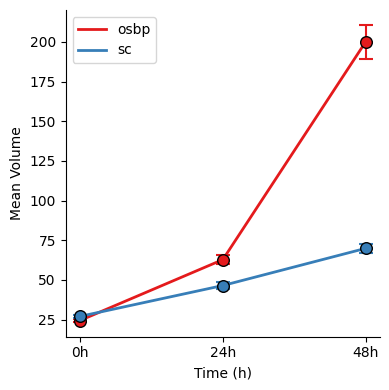

In [27]:
plot_mean_se_curves_from_wide(df, directory_path, figure_name = f"curve_volumes_bact", size=(4, 4))

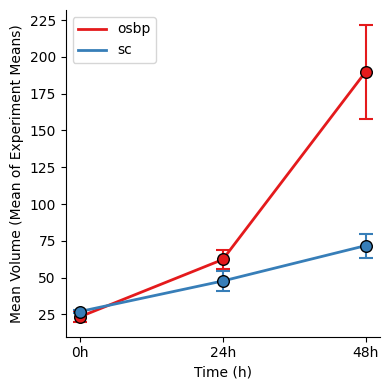

In [51]:
final_summary1 = plot_mean_se_curves_experiment_level(df, directory_path, figure_name = f"curve_volumes_bact", size=(4, 4))

In [28]:
df_path2 = f"{directory_path}/volumes_concat_LC3.csv"
df2 = pandas.read_csv(df_path2)

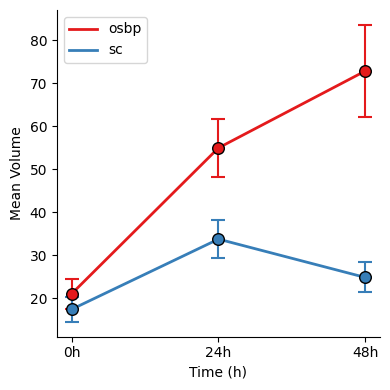

In [30]:
plot_mean_se_curves_from_wide(df2, directory_path, figure_name = f"curve_volumes_LC3", size=(4, 4))

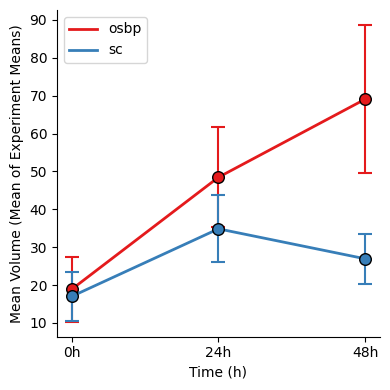

In [52]:
final_summary2 = plot_mean_se_curves_experiment_level(df2, directory_path, figure_name = f"curve_volumes_bact", size=(4, 4))

In [53]:
final_summary1.head()

,condition,time,mean,sem
0,osbp,0h,23.415157,3.459662
1,osbp,24h,62.339200,6.342293
2,osbp,48h,189.909394,31.824470
3,sc,0h,27.000453,1.029141
4,sc,24h,47.739054,6.563048


In [54]:
final_summary2.head()

,condition,time,mean,sem
0,osbp,0h,18.867506,8.573153
1,osbp,24h,48.468024,13.155188
2,osbp,48h,69.103503,19.600308
3,sc,0h,17.004634,6.498032
4,sc,24h,34.854292,8.854407


In [55]:
output_summary2 = f"{directory_path}/volumes_concat_LC3_means.csv"
output_summary1 = f"{directory_path}/volumes_concat_bact_means.csv"
final_summary1.to_csv(output_summary1)
final_summary2.to_csv(output_summary2)